In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sacc
import pyccl as ccl

# Defining the Fiducial Cosmology

Let's create a `Cosmology` obect in CCL and define a reasonable $\Lambda$CDM scenario. The `Cosmology` object will keep track of our cosmological parameters, as well as some extra parameters for the method to compute the matter power spectrum. 

In [2]:
cosmo = ccl.Cosmology(
    Omega_c=0.25,
    Omega_b=0.05,
    w0=-1.0,
    wa=0.0,
    A_s = 2.e-9,
    n_s=0.97,
    h=0.7,
    Omega_k=0.0,
    m_nu = 0.1,
    mass_split = 'equal',
    matter_power_spectrum = "camb",
    extra_parameters = {"camb": {"halofit_version": "mead2020"}}
)

# Loading in our n(z)'s

To save some time, I have pre-computed the phtoometric redshift distributions for this lesson. Let's read them in now and plot them to get a sense of the locations of the binned distributions in redshift. The distributions here are the same as those defined in the Science Requirements Document for Year 1 of LSST. The distribution used for galaxy clustering measurements is typically called the "lens" sample and the distribution used for cosmic shear measurements the "source" sample. 

In [3]:
z_arr = np.genfromtxt('z_values.txt')
nz_bins_lens = (np.genfromtxt('nz_y1_lens.txt')).T
nz_bins_src = (np.genfromtxt('nz_y1_source.txt')).T

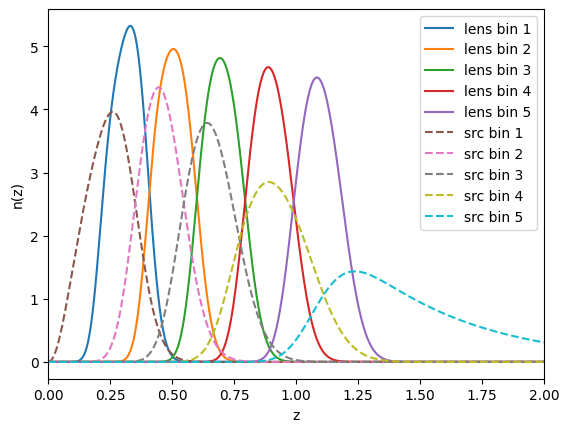

In [4]:
for i in range(len(nz_bins_lens)):
    plt.plot(z_arr, nz_bins_lens[i], label='lens bin %d'%(i+1))

for i in range(len(nz_bins_src)):
    plt.plot(z_arr, nz_bins_src[i], label='src bin %d'%(i+1), ls='--')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.xlim(0.0, 2.0)
plt.legend()
plt.show()

# Defining the Binning Scheme of our Data Vector

We'll bin in $\ell$ from $20 \leq \ell \leq 2000$ into 20 log-spaced bins (10 per decade). Note that this is *choice* and that this can vary from analysis to analysis. Feel free to change this for your own analysis. 

In [5]:
nbin_ell = 20
lmin = 20
lmax = 2000

ells = np.geomspace(lmin, lmax, 2*nbin_ell+1)
ell_edges = ells[0::2]
ell_centers = ells[1::2]

We will also need to define some window functions in $\ell$. you can consider more complicated windows (e.g. with mode coupling), but for this example we will define and utilize simple Top Hat window functions. We will save them in a `sacc` format for future use.

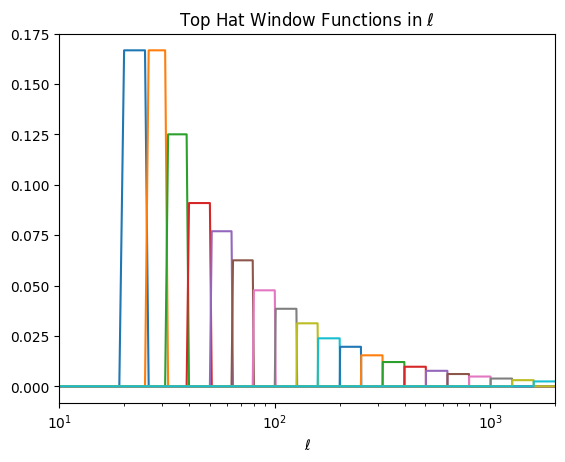

In [6]:
# tophat window functions in ell
ell_unbinned = np.arange(0, lmax+1)
n_ell_unbinned = len(ell_unbinned)
ell_windows = np.zeros([len(ell_unbinned), nbin_ell])
for i in range(nbin_ell):
    ell_windows[:,i] = (ell_unbinned>=ell_edges[i]) & (ell_unbinned<=ell_edges[i+1])
    ell_windows[:,i]/=np.sum(ell_windows[:,i])
    plt.plot(ell_unbinned, ell_windows[:,i], label=r'$\ell$ window '+str(i+1))

sacc_ell_windows = sacc.BandpowerWindow(ell_unbinned, ell_windows)

plt.xlim(10, lmax)
plt.xscale('log')
plt.xlabel('$\ell$')
plt.title('Top Hat Window Functions in $\ell$')
plt.show()


# Cosmic Shear 2PCF

We will first calculate the theoretical value of the cosmic shear 2PCF. Let's consider correlations in the second redshift bin to start. 

First, we will need to create a `WeakLensingTracer` object in CCL. This particular object is a subclass of the `Tracer` object, which keeps track of the kind of physical measurment we are observing as well as information on the observation's systematics. CCL currently supports weak lensing, galaxy number counts, cmb lensing, ISW, tSZ, and CIB measurements as possible tracers. 

In [7]:
shear_only = ccl.WeakLensingTracer(cosmo,
                      has_shear = True,
                      dndz=(z_arr, nz_bins_src[1]),
                      use_A_ia=False
                     )

Now, let's add some complexity. Let's define another `WeakLensingTracer` that includes some basic Intrinsic Alignment modeling. We will use the NLA model without any redshift dependencies. 

In [8]:
IA_amplitude = 1.0
IA = (z_arr, IA_amplitude*np.ones_like(z_arr))

shear_and_IA = ccl.WeakLensingTracer(cosmo,
                      has_shear = True,
                      dndz=(z_arr, nz_bins_src[1]),
                      ia_bias = IA,
                      use_A_ia=True
                     )

Let's calculate a cosmic shear 2PCF. Let's calculate both the shear-only and the shear+IA 2PCFs and plot them!

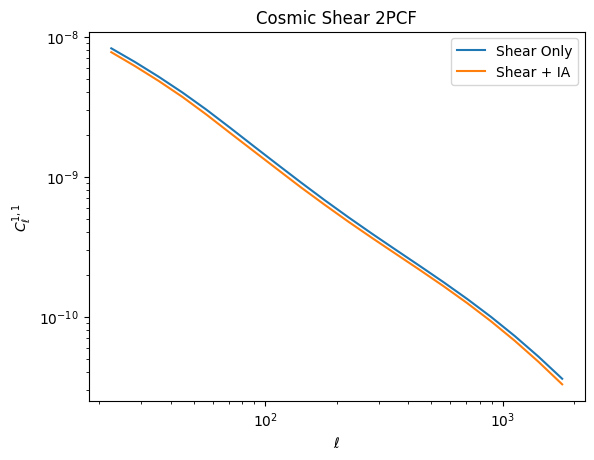

In [9]:
shear_2pcf = ccl.angular_cl(cosmo, shear_only, shear_only, ell_centers)
shear_ia_2pcf = ccl.angular_cl(cosmo, shear_and_IA, shear_and_IA, ell_centers)

plt.loglog(ell_centers, shear_2pcf, label='Shear Only')

plt.loglog(ell_centers, shear_ia_2pcf, label='Shear + IA')
plt.title('Cosmic Shear 2PCF')
plt.ylabel(r'$C_\ell^{1,1}$')
plt.xlabel(r'$\ell$')
plt.legend()
plt.show()

# Galaxy Clustering 2PCF

We will now calculate the theoretical value of the galaxy clustering 2PCF. Let's consider correlations in the first redshift bin this time and define a `NumberCountsTracer` to calculate the 2PCF.


In [10]:
g_bias_amplitudes = np.array([1.24, 1.38, 1.52, 1.68, 1.83])
g_bias = (z_arr, g_bias_amplitudes[0]*np.ones(len(z_arr)))
gbias_only  = ccl.NumberCountsTracer(cosmo, 
                       has_rsd=False, 
                       dndz=(z_arr, nz_bins_lens[0]), 
                       bias=g_bias, 
                       mag_bias = None
                       )

Let's once again add some complexity and consider adding magnification bias terms to the analysis. *Note that zero magnification bias coefficients do not correspond to no magnification bias*. 

In [11]:
mag_bias_amplitudes = np.array([0.0,0.0,0.0,0.0,0.0])

mag_bias = (z_arr, mag_bias_amplitudes[0]*np.ones(len(z_arr)))

gbias_and_magbias = ccl.NumberCountsTracer(cosmo, 
                       has_rsd=False, 
                       dndz=(z_arr, nz_bins_lens[0]), 
                       bias=g_bias, 
                       mag_bias = mag_bias
                       )

Now we can calcualte the 2PCFs for each combination. We will also consider calculating the galaxy clustering 2PCF with the full non-Limber treatment. Do do this, we simply add two parameters to the `angular_cl` function: `l_limber`, which defines the $ell$ mode past which we calculate our 2PCFs with the Limber approximation, and `non_limber_integration_method`, which defaults to the FKEM method of the N5K challenge. More options will be added in the future!

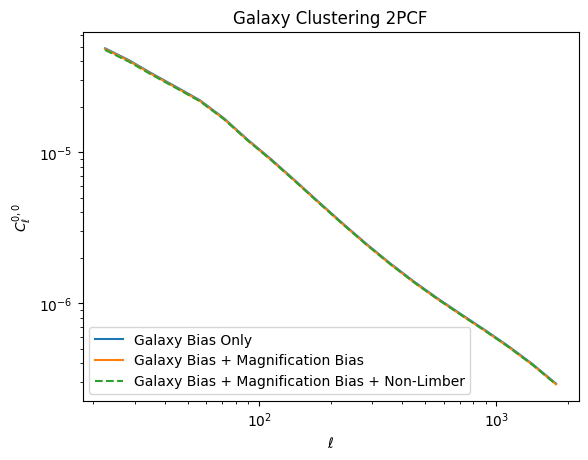

In [12]:
gbias_2pcf = ccl.angular_cl(cosmo, gbias_only, gbias_only, ell_centers)
gbias_magbias_2pcf = ccl.angular_cl(cosmo, gbias_and_magbias, gbias_and_magbias, ell_centers)
gbias_magbias_nonlimber_2pcf = ccl.angular_cl(cosmo, gbias_and_magbias, gbias_and_magbias, ell_centers, l_limber=np.max(ells), non_limber_integration_method="FKEM")

plt.loglog(ell_centers, gbias_2pcf, label='Galaxy Bias Only')
plt.loglog(ell_centers, gbias_magbias_2pcf, label='Galaxy Bias + Magnification Bias')
plt.loglog(ell_centers, gbias_magbias_nonlimber_2pcf, label='Galaxy Bias + Magnification Bias + Non-Limber', ls='--')
plt.title('Galaxy Clustering 2PCF')
plt.ylabel(r'$C_\ell^{0,0}$')
plt.xlabel(r'$\ell$')
plt.legend()
plt.show()

Now we do the same calculation using the `PTTracer` object. The `PTTracer` is a CCL tracer that can calculate higher-order systematics with the help of a `PTCalculator`. When it's done calculating, it will return biased power spectra instead of correlation functions. It is then up to us to assemble the correlation functions properly with our power spectra. Take a look below and see how we can do it by separating linear and non-linear systematics into two different `NumberCountsTracer` definitions. 



*Note when calculating the non-Limber 2PCF with FKEM using PTTracer power spectra, the method also requires evaluations with the lienar power spectrum, which is passed through the `p_of_k_a_lin` variable.*

In [13]:
ptc = ccl.nl_pt.EulerianPTCalculator(
    with_NC=True,
    with_IA=True,
    log10k_min=-4,
    log10k_max=4,
    nk_per_decade=200,
    cosmo=cosmo,
)


ptc_lin = ccl.nl_pt.EulerianPTCalculator(
    with_NC=True,
    with_IA=True,
    log10k_min=-4,
    log10k_max=4,
    nk_per_decade=200,
    cosmo=cosmo,
    b1_pk_kind = 'linear'
)

#need one tracer with the higher-order systematic set to ones
gtracer_no_mag = ccl.NumberCountsTracer(cosmo, 
                                      has_rsd=False, 
                                      dndz=(z_arr, nz_bins_lens[0]), 
                                      bias=(z_arr,np.ones(len(z_arr))), 
                                      mag_bias=None
                                    )
#need another tracer with the higher-order systematic set to None and all other systematics set

gtracer_with_mag = ccl.NumberCountsTracer(cosmo, 
                                      has_rsd=False, 
                                      dndz=(z_arr, nz_bins_lens[0]), 
                                      bias=None, 
                                      mag_bias=mag_bias
                                    )

#defining PTTracers
ptt_m = ccl.nl_pt.PTMatterTracer()
ptt_g = ccl.nl_pt.PTNumberCountsTracer(b1=g_bias_amplitudes[0], b2=0.0, bs=0.0, bk2 = 0.0, b3nl=0.0)

#Calculating biased power spectra
pk_mm = ptc.get_biased_pk2d(tracer1=ptt_m, tracer2=ptt_m)
pk_gm = ptc.get_biased_pk2d(tracer1=ptt_m, tracer2=ptt_g)
pk_gg = ptc.get_biased_pk2d(tracer1=ptt_g, tracer2=ptt_g)
pk_mm_lin = ptc_lin.get_biased_pk2d(tracer1=ptt_m, tracer2=ptt_m)
pk_gm_lin = ptc_lin.get_biased_pk2d(tracer1=ptt_m, tracer2=ptt_g)
pk_gg_lin = ptc_lin.get_biased_pk2d(tracer1=ptt_g, tracer2=ptt_g)

#calculating correlation functions
cl_gm = ccl.angular_cl(cosmo, gtracer_no_mag, gtracer_with_mag, ell_centers, p_of_k_a=pk_gm, l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gm_lin)
cl_mm =ccl.angular_cl(cosmo, gtracer_with_mag, gtracer_with_mag, ell_centers, l_limber=np.max(ells), non_limber_integration_method="FKEM")
cl_mg = ccl.angular_cl(cosmo, gtracer_with_mag, gtracer_no_mag, ell_centers, p_of_k_a=pk_gm, l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gm_lin)
cl_gg = ccl.angular_cl(cosmo, gtracer_no_mag, gtracer_no_mag, ell_centers, p_of_k_a=pk_gg, l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gg_lin)
cl_total = cl_gg + cl_gm + cl_mg + cl_mm

Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.


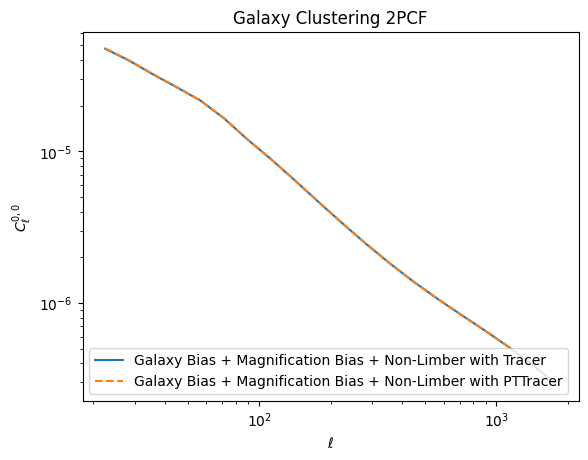

In [14]:
plt.loglog(ell_centers, gbias_magbias_nonlimber_2pcf, label='Galaxy Bias + Magnification Bias + Non-Limber with Tracer')
plt.loglog(ell_centers, cl_total, label='Galaxy Bias + Magnification Bias + Non-Limber with PTTracer', ls='--')


plt.title('Galaxy Clustering 2PCF')
plt.ylabel(r'$C_\ell^{0,0}$')
plt.xlabel(r'$\ell$')
plt.legend()
plt.show()

# Galaxy-Galaxy Lensing 2PCF

Finally, we will now calculate the theoretical value of the galaxy-galaxy lensing (GGL) 2PCF, correlating galaxy positions in the first lens redshift bin with galaxy shapes and orientations in the second source redshift bin. 

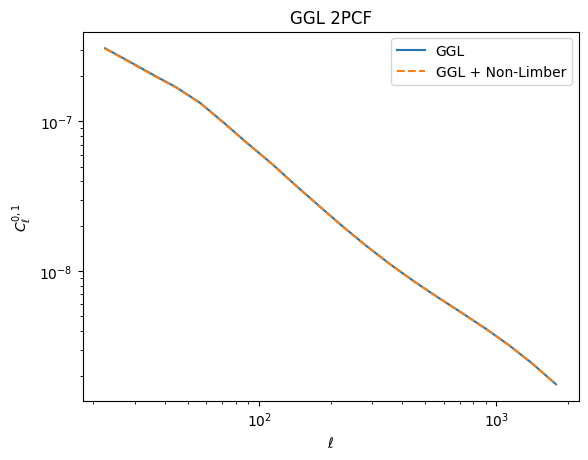

In [15]:
ggl_2pcf = ccl.angular_cl(cosmo, gbias_and_magbias, shear_and_IA, ell_centers)
ggl_nonlimber_2pcf =  ccl.angular_cl(cosmo, gbias_and_magbias, shear_and_IA, ell_centers, l_limber=np.max(ells), non_limber_integration_method="FKEM")

plt.loglog(ell_centers, ggl_2pcf, label='GGL')
plt.loglog(ell_centers, ggl_nonlimber_2pcf, label='GGL + Non-Limber', ls='--')
plt.title('GGL 2PCF')
plt.ylabel(r'$C_\ell^{0,1}$')
plt.xlabel(r'$\ell$')
plt.legend()
plt.show()

# Going to Configuration Space

In practice, the data/correlation functions we measure will be a function of their angular separation on the sky. Let's calculate our 2PCFs in configuration space and plot them!

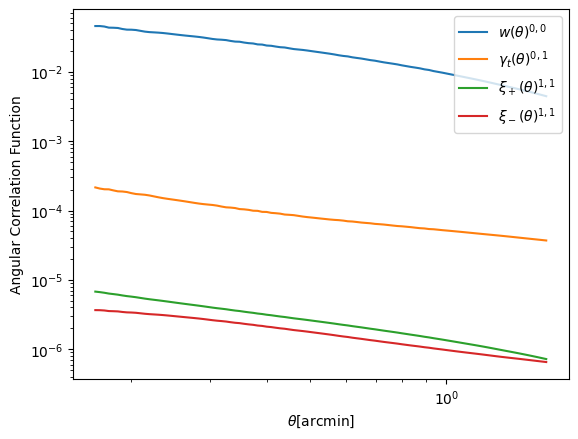

In [16]:
theta = np.geomspace(10, 100, 101)/60 #in arcminutes

gg_corr = ccl.correlation(cosmo, ell=ell_centers, C_ell=gbias_magbias_nonlimber_2pcf, theta=theta, type='NN')
xi_p_corr = ccl.correlation(cosmo, ell=ell_centers, C_ell=shear_ia_2pcf, theta=theta, type='GG+')
xi_m_corr = ccl.correlation(cosmo, ell=ell_centers, C_ell=shear_ia_2pcf, theta=theta, type='GG-')
gamma_t_corr = ccl.correlation(cosmo, ell=ell_centers, C_ell=ggl_nonlimber_2pcf, theta=theta, type='NG')

plt.loglog(theta, gg_corr, label=r'$w(\theta)^{0,0}$')
plt.loglog(theta, gamma_t_corr, label=r'$\gamma_t(\theta)^{0,1}$')

plt.loglog(theta, xi_p_corr, label=r'$\xi_+(\theta)^{1,1}$')
plt.loglog(theta, xi_m_corr, label=r'$\xi_-(\theta)^{1,1}$')

#plt.yscale('symlog')
plt.ylabel('Angular Correlation Function')
plt.xlabel(r'$\theta \mathrm{ [arcmin]}$')
plt.legend()
plt.show()

# Save your Work!

We will translate our CCL tracers into sacc tracers and save our hard work. A `sacc` file is simply an organizational file structure that stores LSST measurement information in an efficient way. We will create a `sacc` structure in the next cell.

In [17]:
s = sacc.Sacc()
dv_sacc_savename = 'my_dv.sacc'

In order to read our data later, we need to store our data, our redshift distributions, our binned data window functions, and useful names to our data combinations. Saccs recognize a few key probes, like galaxy shear and galaxy density, and can store data in Fourier or configuration space. Take a look below on what we're saving to the file. 

In [18]:
s.add_tracer("NZ", "src1", 
             quantity='galaxy_shear',
             z=z_arr,
             nz=nz_bins_src[1]
            )

s.add_tracer('NZ', "lens0",  
             quantity='galaxy_density', 
             z=z_arr,  
             nz=nz_bins_lens[0]
            )

s.add_ell_cl('galaxy_density_cl',
             "lens0", 
             "lens0", 
             ell_centers,  
             gbias_magbias_nonlimber_2pcf,  
             window=sacc_ell_windows
            )

s.add_ell_cl("galaxy_shear_cl_ee", 
              "src1", 
              "src1", 
              ell_centers,  
              shear_ia_2pcf,  
              window=sacc_ell_windows
            )

s.add_ell_cl('galaxy_shearDensity_cl_e',  
             "lens0",  
             "src1", 
             ell_centers,  
             ggl_nonlimber_2pcf,  
             window=sacc_ell_windows
            )

s.save_fits(dv_sacc_savename, overwrite=False)

# Make a Covariance Matrix

Now that we have synthetic data, we want to be able to analyze it and determine the goodness-of-fit for our various synthetic analyses. To evaluate a Likelihood function for these analyses, we first need to compute a covariance matrix. We will use the DESC tool TJPCov to create a simple Gaussian covariance matrix. The `CovarianceCalculator` will require a few configuration parameters stored in a yaml file. Let's take a look at the contents of the file then calculate our covariance matrix.

In [19]:
from tjpcov.covariance_calculator import CovarianceCalculator

data_file = "my_dv.sacc"
cov_save_filename = "my_dv_cov.sacc"
config_yml="cov_setup.yml"

s = sacc.Sacc.load_fits(data_file)
cc = CovarianceCalculator(config_yml)
#print(cc.config)

cov = cc.get_covariance()
s.add_covariance(cov, overwrite=False)
s.save_fits(cov_save_filename, overwrite=False)

[(('lens0', 'lens0'), ('lens0', 'lens0')), (('lens0', 'lens0'), ('lens0', 'src1')), (('lens0', 'lens0'), ('src1', 'src1')), (('lens0', 'src1'), ('lens0', 'src1')), (('lens0', 'src1'), ('src1', 'src1')), (('src1', 'src1'), ('src1', 'src1'))]
Computing independent covariance blocks
Rank None: ('lens0', 'lens0'), ('lens0', 'lens0')
log binning!


/home/paul/.local/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/home/paul/TJPCov/tjpcov/covariance_builder.py:894: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Rank None: ('lens0', 'lens0'), ('lens0', 'src1')
log binning!
Rank None: ('lens0', 'lens0'), ('src1', 'src1')
log binning!
Rank None: ('lens0', 'src1'), ('lens0', 'src1')
log binning!
Rank None: ('lens0', 'src1'), ('src1', 'src1')
log binning!
Rank None: ('src1', 'src1'), ('src1', 'src1')
log binning!
Building the covariance: placing blocks in their place
('lens0', 'lens0') ('lens0', 'lens0')
('lens0', 'lens0') ('lens0', 'src1')
('lens0', 'lens0') ('src1', 'src1')
('lens0', 'src1') ('lens0', 'src1')
('lens0', 'src1') ('src1', 'src1')
('src1', 'src1') ('src1', 'src1')


It's often easier for visualization purposes to plot the correlation matrix rather than the covariance matrix, as the covariance matrix will contain values ranging in orders of magnitude. We have a simple function here to convert our covariance matrix and to plot our covariance matrix by probe combination.

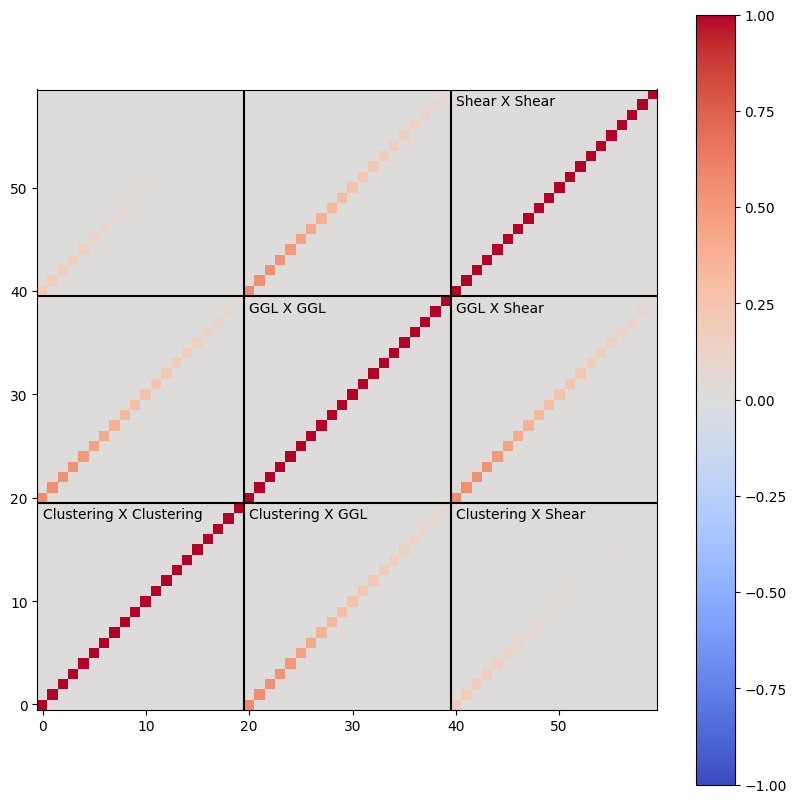

In [20]:
def cov2corr(cov):
    sig = np.sqrt(cov.diagonal())
    return cov/np.outer(sig, sig)
plt.figure(figsize=(10,10))
s = sacc.Sacc.load_fits(cov_save_filename)
cov = s.covariance.covmat
corr = cov2corr(cov)
plt.imshow(corr, origin='lower', cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.hlines([20-0.5,40-0.5], 0-0.5, 60-0.5, color='k')
plt.vlines([20-0.5,40-0.5], 0-0.5, 60-0.5, color='k')
plt.text(0,18,'Clustering X Clustering')
plt.text(20,18,'Clustering X GGL')
plt.text(40,18,'Clustering X Shear')
plt.text(20,38,'GGL X GGL')
plt.text(40,38,'GGL X Shear')
plt.text(40,58,'Shear X Shear')

plt.colorbar()

How do we know the order of the probes in the data vector or the covariance matrix? It's defined by the order of the tracers in the sacc file! We can obtain this order with the `get_tracer_combinations` method. 

In [21]:
labels=s.get_tracer_combinations()
all_data = s.get_mean()
error_bars = np.sqrt(np.diag(cov))

Finally, let's plot our data from the sacc file with their computed error bars. 

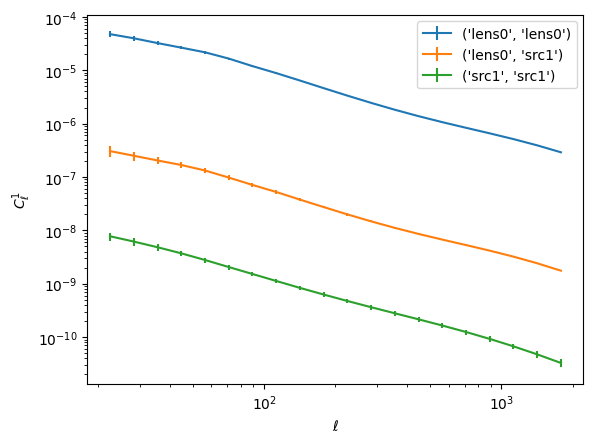

In [22]:
plt.errorbar(ell_centers, all_data[:20], yerr=error_bars[:20], label=labels[0])
plt.errorbar(ell_centers, np.abs(all_data[20:40]), yerr=error_bars[20:40], label=labels[1])
plt.errorbar(ell_centers, all_data[40:], yerr=error_bars[40:], label=labels[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$C_\ell^1$')
plt.xlabel(r'$\ell$')
plt.legend()
plt.show()

And that's the tutorial! Thank you for participating and I hope this was useful for you all. If you have any questions or analyses you'd like to try out, please reach out to me during the Sprint Week on slack @Paul Rogozenski